In [1]:
!pwd

/teamspace/studios/this_studio


In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [7]:
DATA_ROOT= "/teamspace/studios/this_studio/NYC-Uber-Fare-Rate/data"

In [8]:
raw_df = pd.read_csv(os.path.join(DATA_ROOT, 'raw/uber-fare-NewYorkCity.csv'))
# raw_df = pd.read_csv(r"E:\Projects\MLOPS\nyc-uber\NYC-uber-fare-rate\data\raw\uber-fare-NewYorkCity.csv")
raw_df.sample(5)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
125489,31403348,2013-11-09 20:35:00.00000092,8.0,2013-11-09 20:35:00 UTC,-73.985847,40.743887,-73.966222,40.761992,3
56159,11894937,2011-11-25 23:49:21.0000001,11.7,2011-11-25 23:49:21 UTC,-73.985947,40.767971,-74.006434,40.722338,1
1223,51206276,2013-02-21 17:27:00.00000043,7.0,2013-02-21 17:27:00 UTC,-73.981500,40.741160,-73.990800,40.729682,1
48993,7368238,2010-10-13 18:53:25.0000006,10.9,2010-10-13 18:53:25 UTC,-73.981769,40.734360,-73.978862,40.762737,1
17216,48818929,2010-11-12 03:03:00.00000042,8.9,2010-11-12 03:03:00 UTC,-73.986028,40.747217,-74.010885,40.713252,1


In [9]:
data = raw_df.copy()
data = data.dropna()

data = data.drop(['Unnamed: 0', 'key',  'pickup_datetime'], axis=1)
data.sample(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
77010,7.5,-73.990251,40.757006,-73.978395,40.772538,1
86440,24.1,-73.993184,40.692759,-73.872657,40.774496,1
185047,6.0,-73.978920,40.736284,-73.978650,40.747909,1
97491,11.0,-73.977975,40.729584,-73.999812,40.726888,2
21085,9.0,-73.986450,40.751275,-73.997714,40.737709,3


In [12]:
#outlier function
def outlier(dataset, col):

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    result =(lower,upper)

    return list(result)

#data preprocessed
def apply_data_preprocessed(dataset):

  #pick and drop at same location
  zero_distance = dataset[(dataset.pickup_longitude ==dataset['dropoff_longitude']) & (dataset.pickup_latitude==dataset['dropoff_latitude'])].index
  dataset.drop(zero_distance, inplace=True)
  #outlier remove
  dataset = dataset[(dataset.pickup_longitude>=outlier(dataset, 'pickup_longitude')[0]) & (dataset.pickup_longitude<=outlier(dataset, 'pickup_longitude')[1])]
  dataset = dataset[(dataset.pickup_latitude>=outlier(dataset, 'pickup_latitude')[0]) & (dataset.pickup_latitude<=outlier(dataset, 'pickup_latitude')[1])]
  dataset = dataset[(dataset.dropoff_longitude>=outlier(dataset, 'dropoff_longitude')[0]) & (dataset.dropoff_longitude<=outlier(dataset, 'dropoff_longitude')[1])]
  dataset = dataset[(dataset.dropoff_latitude>=outlier(dataset, 'dropoff_latitude')[0]) & (dataset.dropoff_latitude<=outlier(dataset, 'dropoff_latitude')[1])]
  dataset = dataset[(dataset.fare_amount>=outlier(dataset, 'fare_amount')[0]) & (dataset.fare_amount<=outlier(dataset, 'fare_amount')[1])]

  return dataset.reset_index(drop=True)

In [13]:
#preprocessed dataset
data_prep = apply_data_preprocessed(data)



#drop outlier of passenger column
data_prep['passenger_count'].value_counts()
#find index of outlier
index_passenger_outlier = data_prep[data_prep['passenger_count']==208].index
#drop outlier by index
data_prep = data_prep.drop(index=index_passenger_outlier)
#ignore zero passenger
data_prep = data_prep[data_prep['passenger_count'] >= 1]

print("Fully Preprocessed Data for Model Training: \n\n")
data_prep.head()


Fully Preprocessed Data for Model Training: 




,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3
4,9.7,-73.975187,40.745767,-74.002720,40.743537,1


In [14]:
data_prep['passenger_count'].value_counts()

passenger_count
1    112503
2     23678
5     11325
3      7288
4      3498
6      3440
Name: count, dtype: int64

In [15]:
dataset1 = data_prep.copy()

sm = SMOTE(random_state = 42)
data_balanced, passenger_balanced = sm.fit_resample(
    dataset1[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','fare_amount', 'passenger_count']], 
    dataset1['passenger_count'].ravel())
     

In [16]:
data_balanced

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,passenger_count
0,-73.999817,40.738354,-73.999512,40.723217,7.5,1
1,-73.994355,40.728225,-73.994710,40.750325,7.7,1
2,-74.005043,40.740770,-73.962565,40.772647,12.9,1
3,-73.976124,40.790844,-73.965316,40.803349,5.3,3
4,-73.975187,40.745767,-74.002720,40.743537,9.7,1
...,...,...,...,...,...,...
675013,-73.974359,40.783712,-73.974827,40.787391,4.5,6
675014,-73.978134,40.760984,-73.986552,40.749113,6.0,6
675015,-73.964530,40.766739,-73.959783,40.797134,12.0,6
675016,-73.955618,40.779708,-73.993230,40.737617,17.0,6


In [17]:
data_balanced['passenger_count'].value_counts()

passenger_count
1    112503
3    112503
5    112503
2    112503
4    112503
6    112503
Name: count, dtype: int64

In [18]:
X = data_balanced[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]

Y = data_balanced['fare_amount']

In [19]:
# Split your data into 65% training and 35% remaining (testing + validation)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, Y, test_size=0.35, random_state=42, stratify=X['passenger_count'])
     
     
# Further split the remaining data into 57.14% testing and 42.86% validation
# (20% of the original data for testing and 15% for validation)
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.42857, random_state=42, stratify=X_remaining['passenger_count'])
     

In [20]:
X_train['passenger_count'].value_counts()

passenger_count
5    73127
6    73127
2    73127
1    73127
3    73127
4    73126
Name: count, dtype: int64

In [21]:
X_val['passenger_count'].value_counts()

passenger_count
5    16876
4    16876
1    16876
2    16875
6    16875
3    16875
Name: count, dtype: int64

In [22]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
541382,-73.982881,40.726446,-73.985742,40.757792,5
538032,-73.978204,40.778506,-74.003008,40.752463,5
521048,-73.988299,40.728724,-73.979313,40.764933,5
607790,-73.977789,40.778703,-73.985153,40.769079,6
668092,-73.979618,40.753197,-73.970453,40.781347,6


In [23]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

X_val_scaled = sc.transform(X_val)

# Model Building

In [26]:
#different types of regression model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

#error
from sklearn.metrics import mean_absolute_error
#accuracy and R1
from sklearn.metrics import r2_score, explained_variance_score

#best parameters for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
#evaluation of dataset
from sklearn.model_selection import StratifiedKFold

In [27]:
#build models
models = {}

models['Linear Regression'] = {'model' : LinearRegression()}
models['LASSO'] = {'model' : Lasso(alpha =0.1)}
models['Ridge'] = {'model' : Ridge(alpha = 1.0)}
models['KNeighbors Regression'] = {'model' : KNeighborsRegressor()}
models['XGBoost Regression'] = {'model' : XGBRegressor()}
models['RandomForest Regression'] = {'model' : RandomForestRegressor()}

models

{'Linear Regression': {'model': LinearRegression()},
 'LASSO': {'model': Lasso(alpha=0.1)},
 'Ridge': {'model': Ridge()},
 'KNeighbors Regression': {'model': KNeighborsRegressor()},
 'XGBoost Regression': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)},
 'RandomForest R

y_val: 
212348     5.3
607126     9.5
373867     4.1
616913     5.5
635066    15.5
          ... 
244373     4.1
443224    16.5
594408     7.5
138338    16.1
547129     8.0
Name: fare_amount, Length: 101253, dtype: float64
y_pred: 
[8.41068008 8.93234387 8.53754445 ... 8.50149636 7.8546895  8.76977335]
-----------Linear Regression-------------
mean_absolute_error: 2.8216687663359994
R2 score: 0.01300829212298027
explained_variance_score: 0.013021019374433007
y_val: 
212348     5.3
607126     9.5
373867     4.1
616913     5.5
635066    15.5
          ... 
244373     4.1
443224    16.5
594408     7.5
138338    16.1
547129     8.0
Name: fare_amount, Length: 101253, dtype: float64
y_pred: 
[8.54310194 8.65949909 8.53301956 ... 8.34308089 8.46113522 8.61921696]
-----------LASSO-------------
mean_absolute_error: 2.82679799823965
R2 score: 0.009223979612302702
explained_variance_score: 0.009237856358791818
y_val: 
212348     5.3
607126     9.5
373867     4.1
616913     5.5
635066    15.5
    

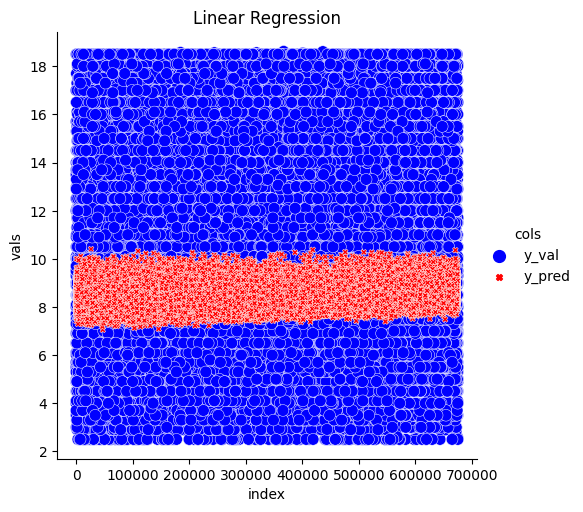

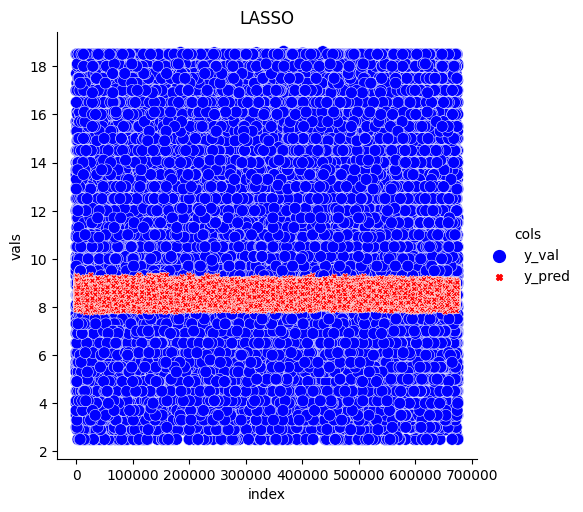

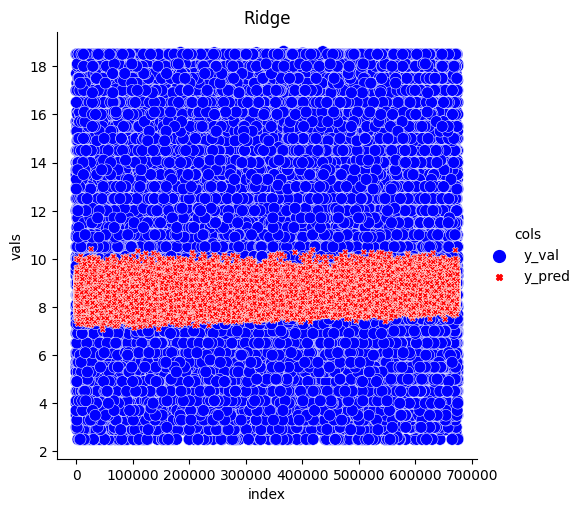

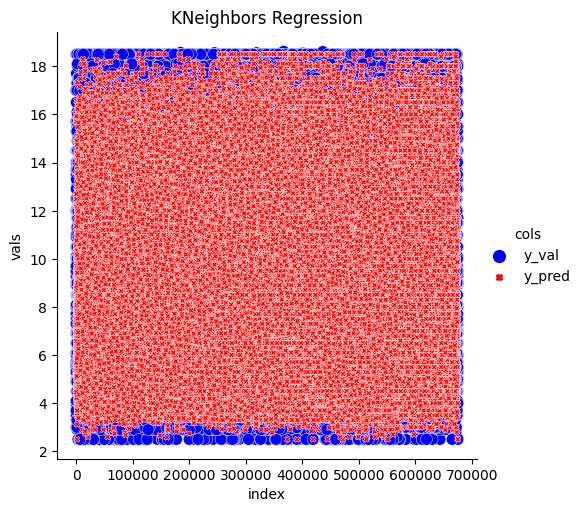

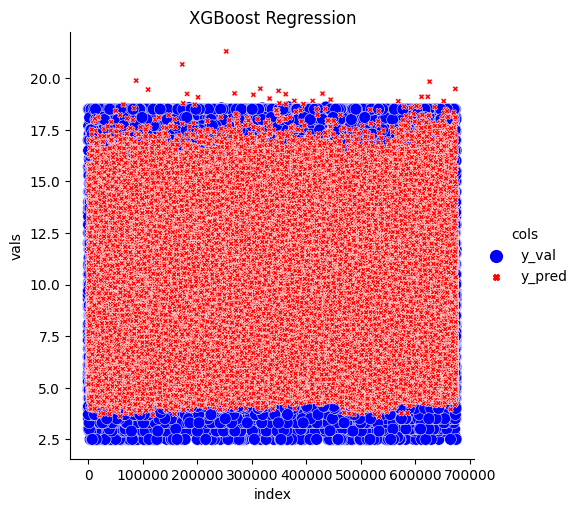

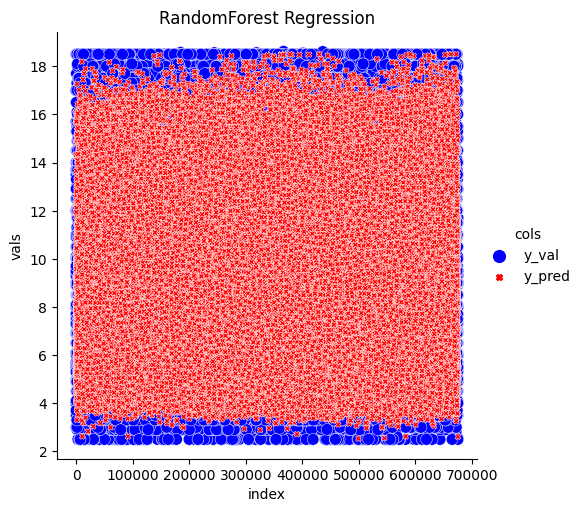

In [28]:
model_name =[]
build_models =[]


for name, model in models.items():
    trained_model = model['model'].fit(X_train_scaled, y_train)
    model_name.append(name)
    build_models.append(trained_model)
    #joblib.dump(reg, '_model.joblib')
    y_pred = trained_model.predict(X_val_scaled)

    print("y_val: ")
    print(y_val)
    print("y_pred: ")
    print(y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred, multioutput='variance_weighted')
    vscore =  explained_variance_score(y_val, y_pred)
    print("-----------"+name+"-------------")
    print(f"mean_absolute_error: {mae}")
    print(f"R2 score: {r2}")
    print(f"explained_variance_score: {vscore}")
    dfm = pd.DataFrame({'index': y_val.index.array, 'y_val': y_val, 'y_pred': y_pred})
    dfmelt = dfm.melt( 'index', var_name='cols', value_name='vals')
    sns.relplot(x= 'index', y="vals", hue='cols', data=dfmelt, size="cols", style="cols",
    palette=["b", "r"]).set(title=name)

#dictionary of models

build_models_dict = dict(zip(model_name, build_models))

In [33]:
build_models_dict.keys()

dict_keys(['Linear Regression', 'LASSO', 'Ridge', 'KNeighbors Regression', 'XGBoost Regression', 'RandomForest Regression'])

In [34]:
build_models_dict.values()

dict_values([LinearRegression(), Lasso(alpha=0.1), Ridge(), KNeighborsRegressor(), XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), RandomForestRegressor()])

In [36]:
import joblib

In [37]:
for k, m in zip(build_models_dict.keys(),build_models_dict.values()):
  joblib.dump(m, k.replace(" ", "_")+'_model.joblib')

# Cross-Validation

In [38]:
cv_folds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle=True)

In [39]:
param_list = {
    'n_neighbors' : [3, 4, 5, 7, 9, 10, 11],
    'weights' : ['uniform', 'distance'],
    'p': [1, 2, 3]
}

grid = GridSearchCV(
    estimator= KNeighborsRegressor(),
    param_grid = param_list,
    cv = 4,
    verbose= 1,
    #scoring='explained_variance_score',
    scoring='neg_mean_absolute_error',
    return_train_score=True)

In [40]:
grid.fit(X_train_scaled, y_train)


Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [41]:
print("Best Parameters: ", grid.best_params_)
print("Best score:", grid.best_score_)

Best Parameters:  {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best score: -0.7544463908620311


# KNN Regressor with Hyperparameter

y_val: 
212348     5.3
607126     9.5
373867     4.1
616913     5.5
635066    15.5
          ... 
244373     4.1
443224    16.5
594408     7.5
138338    16.1
547129     8.0
Name: fare_amount, Length: 101253, dtype: float64
y_pred: 
[ 5.54101292  8.78236498  4.1        ...  7.5        13.16879602
  8.        ]
-----------KNN After Optimization-------------
mean_absolute_error: 0.6793747694790727
R2 score: 0.831388180005865
explained_variance_score: 0.8318086075538345


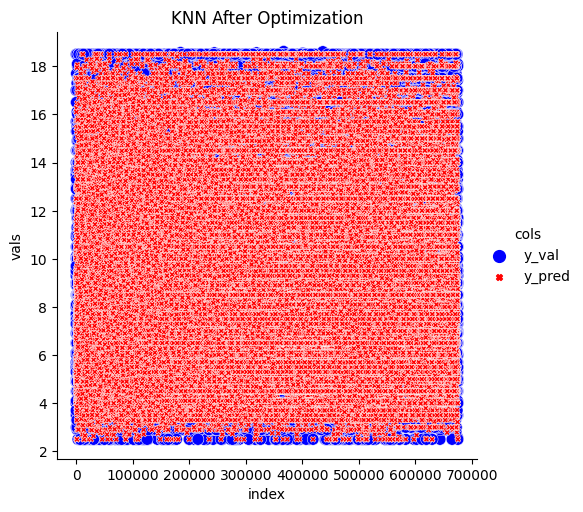

In [42]:
knn_optimized = KNeighborsRegressor(n_neighbors=2, p=2, weights='distance')

model_knn_opt = knn_optimized.fit(X_train_scaled, y_train)
y_pred = model_knn_opt.predict(X_val_scaled)

print("y_val: ")
print(y_val)
print("y_pred: ")
print(y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred, multioutput='variance_weighted')
vscore =  explained_variance_score(y_val, y_pred)

print("-----------"+"KNN After Optimization"+"-------------")
print("mean_absolute_error:", mae)
print("R2 score:", r2)
print("explained_variance_score:", vscore)

dfm1 = pd.DataFrame({'index': y_val.index.array, 'y_val': y_val, 'y_pred': y_pred})
dfmelt1 = dfm1.melt( 'index', var_name='cols', value_name='vals')
sns.relplot(x= 'index', y="vals", hue='cols', data=dfmelt1, size="cols", style="cols",
palette=["b", "r"]).set(title="KNN After Optimization")

# Useen / Test Data Prediction

In [43]:
X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
404761,-73.993141,40.722452,-74.000335,40.738019,4
468781,-74.002563,40.744173,-73.963549,40.760831,5
626658,-73.988096,40.743500,-74.000465,40.735479,6
239815,-74.005739,40.718092,-73.991020,40.736079,2
81826,-73.981897,40.746373,-74.000335,40.730122,1


In [44]:
X_test['passenger_count'].value_counts()

passenger_count
4    22501
6    22501
3    22501
2    22501
5    22500
1    22500
Name: count, dtype: int64

In [45]:

#data normalization
test_unseen_scaled = sc.transform(X_test)
y_pred_test = model_knn_opt.predict(test_unseen_scaled)
print("-----test data evaluation after KNN Optimization-----")
print("y_test: ")
print(y_test)
print("y_pred_test: ")
print(y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
print(f"mae for test_data: {mae}")
r2 = r2_score(y_test, y_pred_test, multioutput='variance_weighted')
print(f"r2_score for test_data: {r2}")
vscore =  explained_variance_score(y_test, y_pred_test)
print(f"variance score for test_data: {vscore}")




-----test data evaluation after KNN Optimization-----
y_test: 
404761    12.0
468781    10.9
626658     6.5
239815     7.7
81826      7.7
          ... 
70004      6.9
523032    12.5
304057     6.1
489361    15.5
36834      8.9
Name: fare_amount, Length: 135004, dtype: float64
y_pred_test: 
[ 8.5        10.9         6.5        ...  6.1        15.5
  9.03898633]
mae for test_data: 0.6837286677963623
r2_score for test_data: 0.8301758191732105
variance score for test_data: 0.8305690731447033


In [46]:
m=model_knn_opt
joblib.dump(m, 'knn_hyper_opti_model.joblib')

['knn_hyper_opti_model.joblib']

In [47]:
def load_model(loader_name, inputs, actual_outputs):
    knn_opt = joblib.load(loader_name)
    predictions = knn_opt.predict(inputs)
    mae = mean_absolute_error(actual_outputs, predictions)
    print(f"mae : $ {mae}")
    return np.array(actual_outputs), predictions

loader_name = "knn_hyper_opti_model.joblib"
inputs = test_unseen_scaled
actual_outputs = y_test
load_model(loader_name, inputs, actual_outputs)
     

mae : $ 0.6837286677963623


(array([12. , 10.9,  6.5, ...,  6.1, 15.5,  8.9]),
 array([ 8.5       , 10.9       ,  6.5       , ...,  6.1       ,
        15.5       ,  9.03898633]))

# Test with single data

In [48]:
X_test.iloc[0]

pickup_longitude    -73.993141
pickup_latitude      40.722452
dropoff_longitude   -74.000335
dropoff_latitude     40.738019
passenger_count       4.000000
Name: 404761, dtype: float64

In [49]:
pickup_longitude = -73.993633
pickup_latitude = 40.722452
dropoff_longitude = -74.000335
dropoff_latitude = 40.738019
passenger_count = 4

new_input = [ pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count]

In [50]:
print(f'input details: {new_input}')

input details: [-73.993633, 40.722452, -74.000335, 40.738019, 4]


In [52]:
def load_model_single_input(loader_model_name, inputs, actual_outputs):
    knn_optimum = joblib.load(loader_name)
    #scaled
    inputs_scaled = sc.transform(inputs)
    predictions =knn_optimum.predict(inputs_scaled)

    return actual_outputs, predictions

loader_model_name = "./knn_hyper_opti_model.joblib"
inputs = np.array(new_input).reshape(1, -1)
actual_outputs = y_test.loc[y_test.index[0]]
load_model_single_input(loader_name, inputs, actual_outputs)

(12.0, array([8.5]))